In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
x = []
y = []
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import shutil
datadir = r'/kaggle/input/brain-tumor-mri-images-44c'
Categories = []
for file_label in os.listdir(datadir):
    Categories.append(file_label)
    for file_name in os.listdir(datadir+'/'+file_label):
        x.append(datadir+'/'+file_label+'/'+file_name)
        y.append(file_label)
dataset=pd.DataFrame({
        'image_path' : x,
        'label' : y
    })


train_datagen = ImageDataGenerator(horizontal_flip= True)
test_datagen = ImageDataGenerator()


train_df, test_df = train_test_split(dataset, test_size=0.3, shuffle=True, random_state=123, stratify=dataset['label'])
test_df, valid_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=123)
training_set = train_datagen.flow_from_dataframe( train_df, 
                                       x_col= 'image_path', 
                                       y_col= 'label', 
                                       target_size= (224,224), 
                                       class_mode= 'categorical',
                                       color_mode= "rgb", 
                                       shuffle= True, 
                                       batch_size= 32)


vald_set = test_datagen.flow_from_dataframe( valid_df, 
                                       x_col= 'image_path', 
                                       y_col= 'label', 
                                       target_size= (224,224), 
                                       class_mode= 'categorical',
                                       color_mode= "rgb", 
                                       shuffle= True, 
                                       batch_size= 32)


test_set = test_datagen.flow_from_dataframe( test_df, 
                                      x_col= 'image_path', 
                                      y_col= 'label', 
                                      target_size= (224,224), 
                                      class_mode= 'categorical',
                                      color_mode= "rgb", 
                                      shuffle= False, 
                                      batch_size= 32)

Found 3134 validated image filenames belonging to 44 classes.
Found 672 validated image filenames belonging to 44 classes.
Found 672 validated image filenames belonging to 44 classes.


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  "These filename(s) will be ignored.".format(n_invalid, x_col)


In [2]:
from tensorflow.keras.applications import ResNet50V2,VGG16
from keras.models import Sequential
from keras.layers import Dense,Input,Conv2D,Dropout,MaxPooling2D,Flatten
from keras.models import *
from keras.layers import *
from keras.preprocessing import image
from PIL import Image
base_model = VGG16(include_top= False, weights= "imagenet",input_shape= (224, 224,3), pooling= 'max')

58889256/58889256 [==============================] - 3s 0us/step


In [4]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(44, activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 44)                11308     
                                                                 
Total params: 14,859,372
Trainable params: 14,858,348
Non-trainable params: 1,024
________________________________________

In [5]:
model.summary()
from keras import callbacks
early_stopping = callbacks.EarlyStopping(
    patience = 15,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.001,
)
checkpoint_name = 'best_model.h5' 
checkpoint=callbacks.ModelCheckpoint('inception_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 44)                11308     
                                                                 
Total params: 14,859,372
Trainable params: 14,858,348
Non-trainable params: 1,024
________________________________________

In [6]:
result=model.fit(training_set, validation_data = vald_set, epochs=100,shuffle=False,callbacks = [early_stopping,checkpoint])

Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 8.4347 - accuracy: 0.1713
Epoch 1: val_loss improved from inf to 9.12098, saving model to inception_model_weights.h5
98/98 [==============================] - 66s 540ms/step - loss: 8.4347 - accuracy: 0.1713 - val_loss: 9.1210 - val_accuracy: 0.1935
Epoch 2/100
98/98 [==============================] - ETA: 0s - loss: 6.9171 - accuracy: 0.2683
Epoch 2: val_loss improved from 9.12098 to 7.58818, saving model to inception_model_weights.h5
98/98 [==============================] - 26s 262ms/step - loss: 6.9171 - accuracy: 0.2683 - val_loss: 7.5882 - val_accuracy: 0.1607
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 6.0314 - accuracy: 0.3207
Epoch 3: val_loss improved from 7.58818 to 7.18443, saving model to inception_model_weights.h5
98/98 [==============================] - 26s 261ms/step - loss: 6.0314 - accuracy: 0.3207 - val_loss: 7.1844 - val_accuracy: 0.1161
Epoch 4/100
98/98 [===================

In [9]:
model.load_weights('/kaggle/working/inception_model_weights.h5')

In [10]:
model.evaluate(test_set)

21/21 [==============================] - 4s 184ms/step - loss: 0.3936 - accuracy: 0.9464


[0.39363113045692444, 0.9464285969734192]

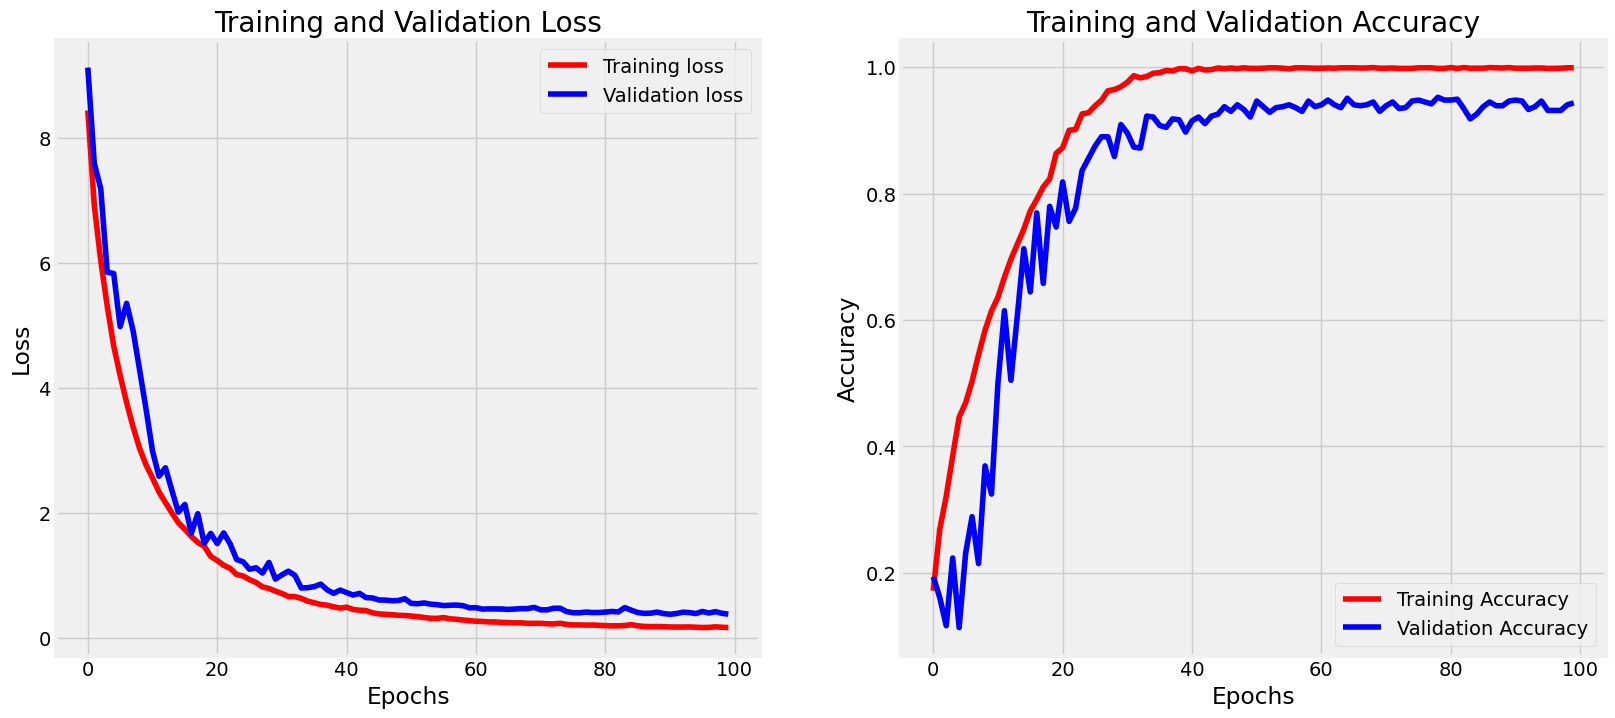

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(result.history['loss'], 'r', label= 'Training loss')
plt.plot(result.history['val_loss'], 'b', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(result.history['accuracy'], 'r', label= 'Training Accuracy')
plt.plot(result.history['val_accuracy'], 'b', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.savefig('vgg16.png')
plt.show()